In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

학습 및 테스트 데이터 읽어오기

In [ ]:
dftrain = pd.read_csv('./data/train_job/train.csv')
dftest = pd.read_csv('./data/test_job.csv')

test = dftest.copy()

학습 데이터 확인해보기

In [6]:
dftrain.head()

,userID,jobID,applied
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0
1,6377fa90618fae77571e8dc90d98d409,55b37c5c270e5d84c793e486d798c01d,0
2,8ec0888a5b04139be0dfe942c7eb4199,0fcbc61acd0479dc77e3cccc0f5ffca7,1
3,f862b39f767d3a1991bdeb2ea1401c9c,3b5dca501ee1e6d8cd7b905f4e1bf723,0
4,cac14930c65d72c16efac2c51a6b7f71,287e03db1d99e0ec2edb90d079e142f3,0


데이터가 암호화 되어 있어서, 이 암호화된 string을 정수로 바꿔줘야 할 것 같다.

학습 및 테스트 데이터를 변환하기 전에, `userID`와 `jobID`에 관련된 추가 정보들이 담긴 `csv`파일들을 더 불러온다.

In [7]:
df_job_companies = pd.read_csv('./data/train_job/job_companies.csv')
df_job_tags = pd.read_csv('./data/train_job/job_tags.csv')
df_tags = pd.read_csv('./data/train_job/tags.csv')
df_user_tags = pd.read_csv('./data/train_job/user_tags.csv')

In [8]:
print('job_companies.csv : ', df_job_companies.columns)
print('job_tags.csv : ', df_job_tags.columns)
print('tags.csv : ', df_tags.columns)
print('user_tags.csv : ', df_user_tags.columns)


job_companies.csv :  Index(['companyID', 'jobID', 'companySize'], dtype='object')
job_tags.csv :  Index(['jobID', 'tagID'], dtype='object')
tags.csv :  Index(['tagID', 'keyword'], dtype='object')
user_tags.csv :  Index(['userID', 'tagID'], dtype='object')


In [43]:
print(df_job_companies.head())
print('Percent of missing "companySize" records is {:.2f}%'.format((df_job_companies['companySize'].isna().sum())/df_job_companies.shape[0] * 100) )

                          companyID                             jobID  \
0  00411460f7c92d2124a67ea0f4cb5f85  e5f6ad6ce374177eef023bf5d0c018b6   
1  1905aedab9bf2477edc068a355bba31a  185e65bc40581880c4f2c82958de8cfe   
2  89fcd07f20b6785b92134bd6c1d0fa42  0537fb40a68c18da59a35c2bfe1ca554   
3  acf4b89d3d503d8252c9c4ba75ddbf6d  b7ee6f5f9aa5cd17ca1aea43ce848496   
4  fb7b9ffa5462084c5f4e7e85a093e6d7  efe937780e95574250dabe07151bdc23   

  companySize  
0         NaN  
1       11-50  
2     101-200  
3        1-10  
4         NaN  
Percent of missing "companySize" records is 12.28%


* 90개의 회사가 `companySize` 데이터가 존재하지 않음(`NaN`)
* `jobID`는 `companyID`, `companySize`, `tagID`와 관련이 있으며, `userID`는 `tagID`와 관련이 있음
    * `companyID`는 unique 하므로, `jobID`와 차이가 없음
    * `companySize`의 데이터를 정리할 필요가 있음

In [ ]:
df_job_companies["companySize"].replace(
    {"1-10": 0, "11-50":1, "51-100":2, "101-200":3, "201-500":4, "501-1000":5, "1000 이상": 6}
    , inplace=True)
df_job_companies.drop("companyID", axis=1, inplace=True)

In [60]:
df_job_companies['companySize'] = df_job_companies['companySize'].astype('Int64')
print(df_job_companies['companySize'].unique())

<IntegerArray>
[<NA>, 1, 3, 0, 2, 6, 4, 5]
Length: 8, dtype: Int64


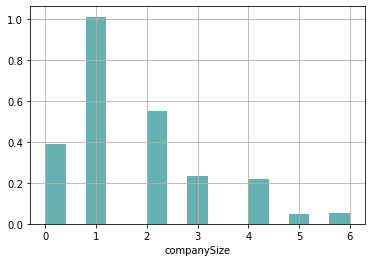

In [62]:
ax = df_job_companies["companySize"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
ax.set(xlabel='companySize')
plt.show()

In [67]:
print('The mean of "companySize" is %.2f' %(df_job_companies["companySize"].mean(skipna=True)))
print('The median of "companySize" is %.2f' %(df_job_companies["companySize"].median(skipna=True)))

The mean of "companySize" is 1.69
The median of "companySize" is 1.00


우선 학습 데이터의 feature가 부족한 것 같으므로, `DataFrame`간 join 연산 수행

In [27]:
print(dftrain.dtypes, df_job_companies.dtypes)
print(dftrain.shape, df_job_companies.shape)
new_df_train = dftrain.merge(df_job_companies, left_on="jobID", right_on="jobID")

userID     category
jobID        object
applied       int64
code          int16
dtype: object companyID      object
jobID          object
companySize    object
dtype: object
(6000, 4) (733, 3)


In [69]:
new_df_train

,userID,jobID,applied,code,companyID,companySize
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0,195,4f6ffe13a5d75b2d6a3923922b3922e5,11-50
1,1d0d19d2d7d31ccf3747614aec7273c8,15de21c670ae7c3f6f3f1f37029303c9,0,17,4f6ffe13a5d75b2d6a3923922b3922e5,11-50
2,c70daf247944fe3add32218f914c75a6,15de21c670ae7c3f6f3f1f37029303c9,0,157,4f6ffe13a5d75b2d6a3923922b3922e5,11-50
3,883b4172416f7b84234d3aeda4199f8f,15de21c670ae7c3f6f3f1f37029303c9,1,107,4f6ffe13a5d75b2d6a3923922b3922e5,11-50
4,6bc5d37951120d6d49672ce647c4e563,15de21c670ae7c3f6f3f1f37029303c9,0,74,4f6ffe13a5d75b2d6a3923922b3922e5,11-50
...,...,...,...,...,...,...
5995,946aa0c612952da8d67dd338a43d5929,f29b38f160f87ae86df31cee1982066f,0,116,e5e63da79fcd2bebbd7cb8bf1c1d0274,501-1000
5996,fd1b4044581c63b9cb16d91958302072,92262bf907af914b95a0fc33c3f33bf6,0,193,193002e668758ea9762904da1a22337c,11-50
5997,b94a3f555cc529e2ef5d5277651a33c1,caf1a3dfb505ffed0d024130f58c5cfa,0,149,4f6ffe13a5d75b2d6a3923922b3922e5,11-50
5998,78492ae8ee0c7aeab730674170296142,7f1171a78ce0780a2142a6eb7bc4f3c8,1,87,7fa732b517cbed14a48843d74526c11a,1-10
